In [5]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем датасет

In [7]:
dataset_email = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/email/")
dataset_resume = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/resume/")
dataset_scientific = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/scientific_publication/")

image_count_email = len(list(dataset_email.glob("*.png")))
image_count_resume = len(list(dataset_resume.glob("*.png")))
image_count_scientific = len(list(dataset_scientific.glob("*.png")))

print(f"Всего изображений email: {image_count_email} , Всего изображений resume: {image_count_resume}, Всего изображений scientific: {image_count_scientific}")

Всего изображений email: 105 , Всего изображений resume: 78, Всего изображений scientific: 102


Нейросеть

In [8]:
batch_size = 2
img_width = 256
img_height = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Kurushin1sem/",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Kurushin1sem/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names
print(f"Class names: { class_names }")

#cache

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


Found 285 files belonging to 3 classes.
Using 228 files for training.
Found 285 files belonging to 3 classes.
Using 57 files for validation.
Class names: ['email', 'resume', 'scientific_publication']


Создаем модель, компилируем и выводим summary

In [9]:
#create model

num_classes = len(class_names)
model = Sequential([
    #локлаьно
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),

    #аугментация
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2),
    #дальше везде одинаково
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    # регулиризация

    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

#компиляция модели

model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
metrics = ['accuracy'])

#print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 3)       0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      4

Обучение модели

Epoch 1/20
114/114 [==============================] - 86s 379ms/step - loss: 1.2873 - accuracy: 0.3728 - val_loss: 1.0632 - val_accuracy: 0.5263
Epoch 2/20
114/114 [==============================] - 34s 295ms/step - loss: 1.1106 - accuracy: 0.3816 - val_loss: 1.1534 - val_accuracy: 0.4211
Epoch 3/20
114/114 [==============================] - 33s 289ms/step - loss: 1.0698 - accuracy: 0.3728 - val_loss: 1.0758 - val_accuracy: 0.2982
Epoch 4/20
114/114 [==============================] - 33s 292ms/step - loss: 1.0876 - accuracy: 0.3991 - val_loss: 1.0442 - val_accuracy: 0.3509
Epoch 5/20
114/114 [==============================] - 33s 290ms/step - loss: 1.0464 - accuracy: 0.4342 - val_loss: 1.0198 - val_accuracy: 0.3860
Epoch 6/20
114/114 [==============================] - 36s 311ms/step - loss: 1.0567 - accuracy: 0.4298 - val_loss: 1.5269 - val_accuracy: 0.3860
Epoch 7/20
114/114 [==============================] - 35s 304ms/step - loss: 1.0668 - accuracy: 0.4254 - val_loss: 1.0456 - val_ac

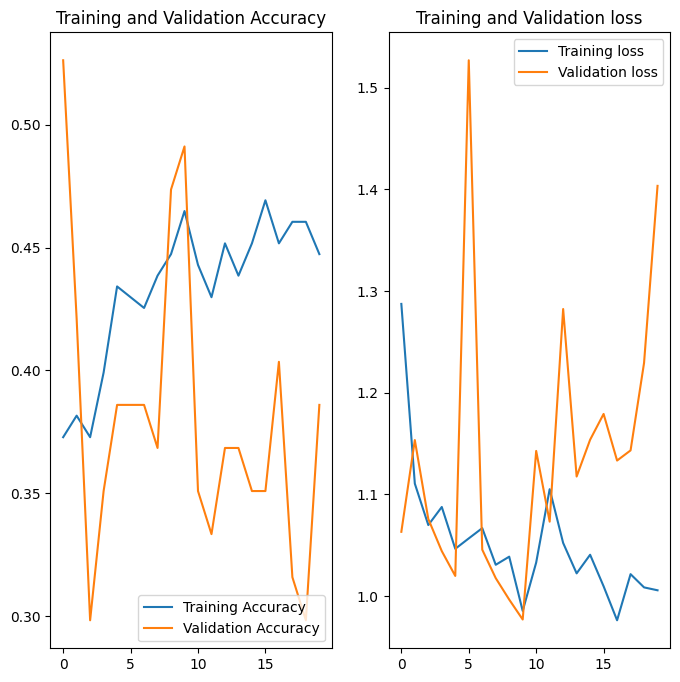

In [10]:
#кол-во эпох обучения

epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

#Визуализируем Training и Validation результаты
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

Сохранение модели


In [12]:
#import os
#
#gdrive_path = "/content/drive/My Drive/TestNeuro/"
#
#filename = gdrive_path + "test.txt"
#with open(filename , 'w') as file:
#    file.write('whatever')
#!ls "/content/drive/My Drive/TestNeuro/"
##
#checkpoint = ModelCheckpoint(gdrive_path + "best_weights.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', period=1)
#model.fit(
#    train_ds,
#    validation_data = val_ds,
#    epochs = epochs
#)

Em1.png  Em3.png     ReadyResume   Res1.jpg  Res3.jpg  Sc2.jpg	test.txt
Em2.png  ReadyEmail  ReadyScience  Res2.jpg  Sc1.jpg   Sc3.png


In [26]:
import os

gdrive_path = "/content/drive/My Drive/TestNeuro/"

filename = gdrive_path
model.save_weights('my_model_weights.h5')
model.save(filename + 'my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


загрузка модели

In [15]:
from keras.models import load_model
model = load_model(filename + 'my_model.h5')

print(f"Загрузка завершена модели: { model }")

Загрузка завершена модели: <keras.src.engine.sequential.Sequential object at 0x7d6d618d7bb0>


Загрузка изображения

In [45]:
import os
from os import path

img = tf.keras.utils.load_img("/content/drive/MyDrive/TestNeuro/Sc6.png", target_size = (img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Сделаем предикаты

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# выводим результаты

print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
class_names[np.argmax(score)],
100 * np.max(score)))

img.show()


1/1 [==============================] - 0s 54ms/step
На изображении скорее всего scientific_publication (37.54% вероятность)


# Новый раздел